In [1]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mywhois
 
# Get the data (csv file is hosted on the web)
# url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/volcano.csv'
# data = pd.read_csv(url)

In [2]:
def prep_dmv_sample(raw_dataframe, save=False, filename="clean_test_data.csv"):
    # Data prep from sample downloaded from web site database

    original_length = len(raw_dataframe)
    print(f"Original length of sample data is {original_length}")

    # Drop data with Result.isna(). These events also have TotalScore=0, IPAddress.isna().
    # - Show them using: df[df["Result"].isna()]
    # - rest_index() is needed after the rows are dropped

    df = raw_dataframe.dropna(axis=0, subset=["Result"]).reset_index(drop=True)

    dropped_nan = original_length - len(df)
    print(f"{dropped_nan} tests with Result, IPAddress, TotalScore = NaN dropped")

    # Add column, ip, with the port number from the reported ip address
    df["ip"] = df.IPAddress.apply(lambda x: x.split(":")[0])

    # Add column, duration, for the TotalTimeSpent in minutes
    df["duration"] = df.TotalTimeSpent/60    

    # Add column, duration, for the TotalTimeSpent in minutes
    df["duration"] = df.TotalTimeSpent/60

    # Some events have more than 1 ip address
    df["multiple_ip"] = df.ip.apply( lambda x: len(x.split(","))>1)

    # Remove the extra ip address from tests with more than 1 ip address
    df.loc[:,"ip"] = df.ip.apply(lambda x: x.split(",")[0])
    print(f'Extra ip address dropped in {len(df[df["multiple_ip"]])} tests')
    
    # Make a copy of the cleaned data
    if save:
        df.to_csv("clean_test_data.csv", index=False)
    return df

In [3]:
# Input data

# Get the data (csv file is hosted on the web)
# url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/volcano.csv'
# data = pd.read_csv(url)
# It looked like:
# 	V1	V2	V3	V4	V5	V6	V7	V8	V9	V10	...	V52	V53	V54	V55	V56	V57	V58	V59	V60	V61
#0	100	100	101	101	101	101	101	100	100	100	...	107	107	107	106	106	105	105	104	104	103
#1	101	101	102	102	102	102	102	101	101	101	...	108	108	107	107	106	106	105	105	104	104
#2	102	102	103	103	103	103	103	102	102	102	...	109	108	108	107	107	106	106	105	105	104
#3	103	103	104	104	104	104	104	103	103	103	...	109	109	108	108	107	107	106	106	105	105
#4	104	104	105	105	105	105	105	104	104	103	...	110	109	109	108	107	107	107	106	106	105
#...	...	...	...	...	...	...	...	...	...	...	...	...	...

sample_filename = "OPT11022021-11042021.csv"

# Read the sample data downloaded from the DMV testing web site
test_sample = pd.read_csv(sample_filename)

# Work with a shallow copy
raw_dataframe = test_sample.copy()

clean = prep_dmv_sample(raw_dataframe, save=True)

Original length of sample data is 4561
110 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 36 tests


In [4]:
df = clean[["TotalScore", "duration", "ip"]]


In [5]:
# Add ip risk
risk = mywhois.Risk("mywhois", readonly=True)
def f(x):
    r = risk.find(x)
    if r:
        return float(r["score"])
    return -1
def g(x):
    r = risk.find(x)
    if r:
        return r["risk"]
    return "Unknown"
vscore = df.loc[:,"ip"].apply(f).copy()
# vrisk = df.loc[:,"ip"].apply(g).copy()
df.loc[:,"score"] = vscore
# df.loc[:,"risk"] = vrisk



/home/bkrawchuk/anaconda3/envs/dmv_test/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [6]:
df = df.drop(columns=["ip"])


In [7]:
# Transform it to a long format
# df = data.unstack().reset_index()

# df.columns=["X","Y","Z"]
df = df.rename(columns={"duration":"X", "score":"Y", "TotalScore":"Z"})

In [8]:
# And transform the old column name in something numeric
#   Not needed because input is already numeric
# df['X']=pd.Categorical(df['X'])
# df['X']=df['X'].cat.codes

In [9]:
df = df[(df.X <= 60)]
# df = df[(df.X <= 20) & (df.Y > 30)]

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


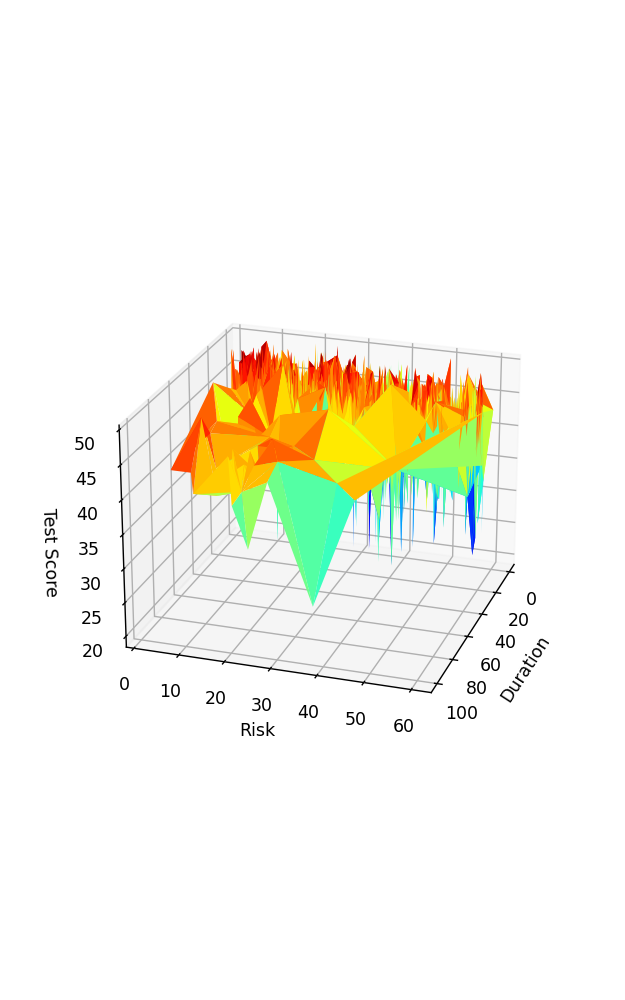

In [11]:
def aes(cmap=plt.cm.viridis, elevation=20, azimuth=35):
    fig = plt.figure(figsize=(5,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("Duration")
    ax.set_ylabel("Risk")
    ax.set_zlabel("Test Score")
    ax.view_init(elevation, azimuth)
    surf = ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=cmap, linewidth=0.2)
    return fig, ax, surf

# # Make the plot
# fig, ax, surf = aes()
# plt.show()
 

# # to Add a color bar which maps values to colors.
# fig, ax, surf = aes()
# fig.colorbar( surf, shrink=0.5, aspect=5)
# plt.show()

# # Rotate it
# fig, ax, surf = aes(elevation=20, azimuth=75)
# # ax.view_init(20, 75)
# plt.show()
 
# Other palette
fig, ax, surf = aes(cmap=plt.cm.jet, elevation=20, azimuth=75)
# ax.view_init(20,75)
plt.show()
    
